In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import pymorphy3
import mlflow

from nltk.corpus import stopwords
from tqdm.auto import tqdm
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

/home/alex/.cache/pypoetry/virtualenvs/aviation-topic-pipeline-XD-grrq7-py3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Предобработка текстов

In [2]:
aeroflot = pd.read_csv('../data/raw/aeroflot_official_posts.csv')
aviatorshina = pd.read_csv('../data/raw/aviatorshina_posts.csv')
favt = pd.read_csv('../data/raw/favt_ru_posts.csv')
s7 = pd.read_csv('../data/raw/s7newsroom_posts.csv')
avia_comments = pd.read_csv('../data/raw/AviaComments_posts.csv')
rumayday = pd.read_csv('../data/raw/rumayday_posts.csv')
aviationmode = pd.read_csv('../data/raw/aviationmode_posts.csv')

**Объединие данных из каналов в один датафрейм**

In [3]:
df = pd.concat([aeroflot, aviatorshina, favt, s7, avia_comments, rumayday, aviationmode], axis=0)
df.head()

,message
0,"Поздравляем, самые любимые 💙\n\nВы научили нас..."
1,☀️ Как победить сезонную хандру? \n\nУчастники...
2,👦На борту наших рейсов юные пассажиры ведут се...
3,❄️ Только представьте: полёт в сопровождении о...
4,✈️✈️✈️✈️✈️✈️✈️✈️\n🎁 Пока вы составляете список...


In [4]:
len(df)

10456

**Удаление пустых значений**

In [5]:
df.isnull().sum()

message    4814
dtype: int64

In [6]:
df = df.dropna()

In [7]:
len(df)

5642

**Обработка дубликатов**

In [8]:
np.sum(df.duplicated())

np.int64(60)

In [9]:
df[df.duplicated]

,message
1851,Актуальные новости мира БАС: В Беларуси физлиц...
1613,#Мнение_экспертов — старшего научного сотрудни...
7,✈️Замруководителя Росавиации Сергей Страмоус п...
116,✈️Статус работ сразу по трем самолетам УЗГА ра...
154,Росавиация аннулирует сертификат эксплуатанта ...
216,✈️ Открыли памятник «Красный Кут — город авиат...
251,Завершаем юбилейные празднования завораживающи...
261,С чего началось празднование 90-летия УИ ГА? С...
287,✈️ Росавиация уведомила российских эксплуатант...
291,✈️Краснодарский аэропорт с 09:00 МСК 11 сентяб...


In [10]:
df = df.drop_duplicates(keep='first')

In [11]:
len(df)

5582

**Анализ длин постов**

In [12]:
df['message_lenght'] = df['message'].apply(lambda x: len(x))
df['word_count'] = df['message'].str.split().str.len()

Text(0.5, 0, 'messages_lenght')

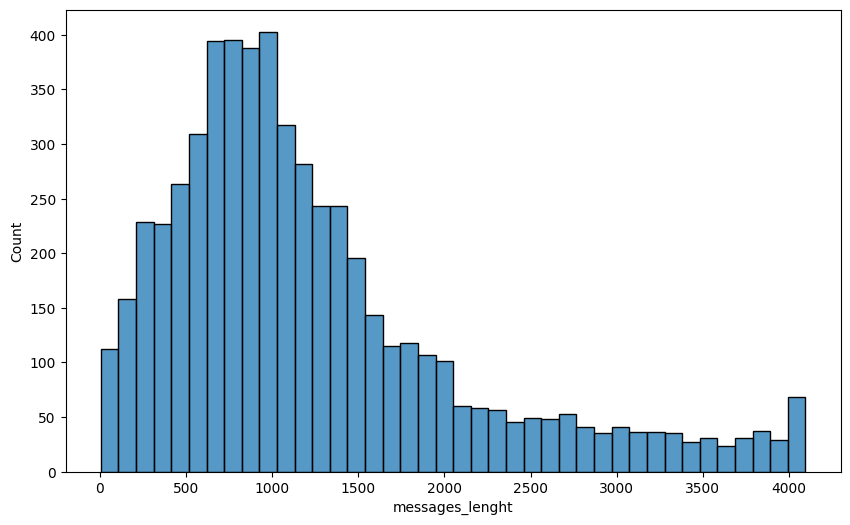

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(x=df['message_lenght'])
plt.xlabel("messages_lenght")

Text(0.5, 0, 'Count of words')

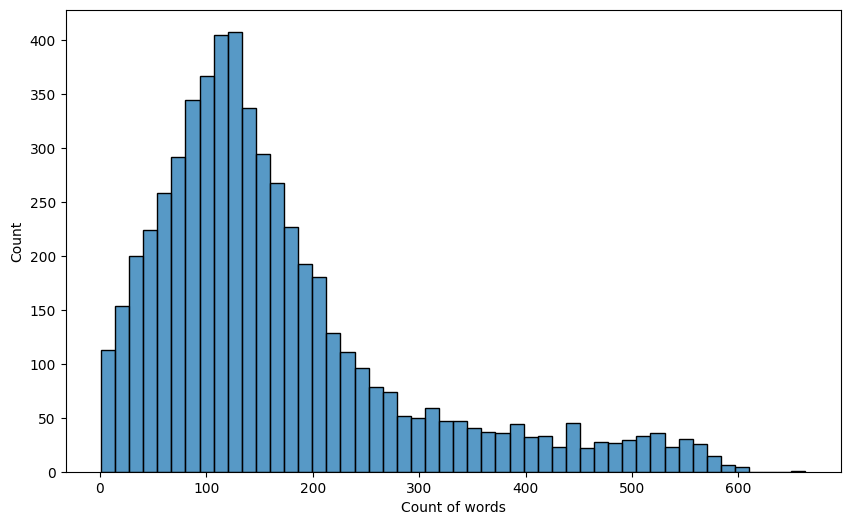

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(x=df['word_count'])
plt.xlabel("Count of words")

**Удалим слишком короткие и слишком длинные сообщения**

In [15]:
filtered_df = df[df['word_count'] <= 400].copy()

filtered_df = filtered_df[
    (filtered_df['message_lenght']) >= 20 & 
    (filtered_df['message_lenght'] <= 2500)
]
    
print(f"После фильтрации: {len(filtered_df)} сообщений")
print(f"Удалено: {len(df) - len(filtered_df)} сообщений")

После фильтрации: 5173 сообщений
Удалено: 409 сообщений


**Предобработка текстов**

In [16]:
# создаём морфологический анализатор
morph = pymorphy3.MorphAnalyzer()

if 'russian_stopwords' not in locals():
      russian_stopwords = stopwords.words("russian")

extra_stopwords = {'наш', 'свой', 'который', 'это', 'весь', 'сам'}

texts_as_lists = []

def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower() # Приведение к нижнему регистру
        text = text.lower()
        text = re.sub(r'[^а-яё]', ' ', text) # Удаление пунктуации, кроме пробелов
        # разбиваем на слова
        words = text.split()
        # приводим к леммам, убираем стоп-слова и короткие слова (это важно для тематическго моделирования)
        lemmas = [morph.parse(word)[0].normal_form for word in words if 
                  word not in russian_stopwords and 
                  morph.parse(word)[0].normal_form not in extra_stopwords and 
                  len(word) > 2]
        texts_as_lists.append(lemmas)
        return " ".join(lemmas)
    return "" # Возвращаем пустую строку для нестроковых значений


print("\nНачало предобработки текста...")
# Применение предобработки к столбцу с текстом. Используем tqdm для отслеживания прогресса.
if 'message' in filtered_df.columns:
    tqdm.pandas()
    filtered_df['processed_text'] = filtered_df['message'].progress_apply(preprocess_text)
    print("Предобработка текста завершена.")
    display(filtered_df.head())


Начало предобработки текста...


100%|██████████| 5173/5173 [00:48<00:00, 107.07it/s]

Предобработка текста завершена.


,message,message_lenght,word_count,processed_text
0,"Поздравляем, самые любимые 💙\n\nВы научили нас...",399,62,поздравлять самый любимый научить смотреть мир...
1,☀️ Как победить сезонную хандру? \n\nУчастники...,784,155,победить сезонный хандра участник аэрофлот бон...
2,👦На борту наших рейсов юные пассажиры ведут се...,767,121,борт рейс юный пассажир вести образцово всё пр...
3,❄️ Только представьте: полёт в сопровождении о...,603,83,представить полёт сопровождение оркестр борт р...
4,✈️✈️✈️✈️✈️✈️✈️✈️\n🎁 Пока вы составляете список...,943,186,пока составлять список подарок новогодний праз...


In [17]:
texts = filtered_df['processed_text']

**Облако слов**

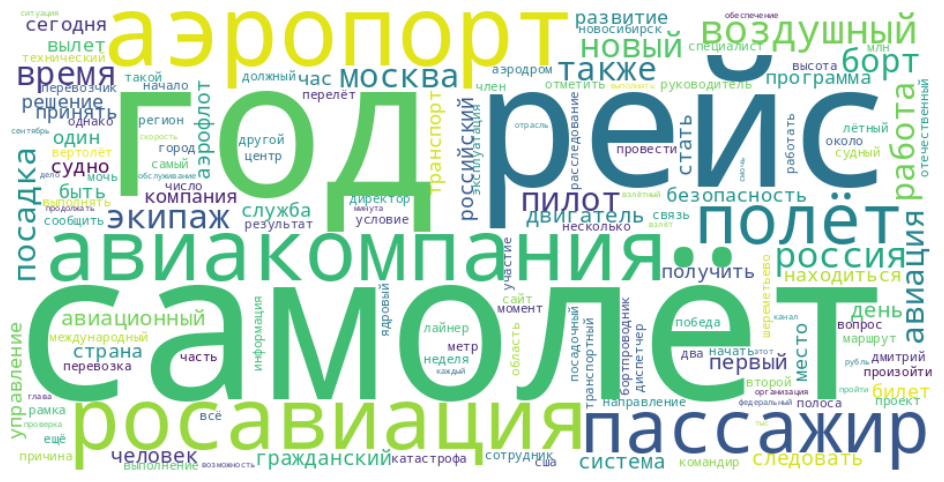

In [18]:
def create_wordcloud(texts, max_words=100):
    all_text = ' '.join(texts)
    
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=max_words,
        colormap='viridis',
        collocations=False
    ).generate(all_text)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
    return wordcloud


wordcloud = create_wordcloud(filtered_df['processed_text'], max_words=150)

## Обучение моделей

### LDA

In [19]:
def train_lda_model(texts, n_topics=10, max_features=2000, random_state=42):
    """
    Обучение LDA модели
    """
    # Векторизация текстов
    vectorizer = CountVectorizer(
        max_features=max_features,
        min_df=2,
        max_df=0.8,
        stop_words=russian_stopwords
    )
    
    X = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    
    print(f"Размер матрицы: {X.shape}")
    print(f"Количество тем: {n_topics}")
    
    # Обучение LDA
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=random_state,
        max_iter=10,
        learning_method='online'
    )
    
    lda.fit(X)
    
    return lda, vectorizer

In [20]:
experiment = mlflow.create_experiment(name="topic_modeling", artifact_location='my-artifacts')

/home/alex/.cache/pypoetry/virtualenvs/aviation-topic-pipeline-XD-grrq7-py3.13/lib/python3.13/site-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)


In [21]:
mlflow.set_tracking_uri("../mlruns")

In [22]:
experiment = mlflow.get_experiment_by_name("topic_modeling")
experiment_id = experiment.experiment_id 

In [23]:
def log_topics_to_mlflow(lda_model, feature_names, n_words=10, filename="topics.txt"):
    """Сохраняет топ-слов тем в файл и логирует в MLflow"""
    
    topics_text = "Топ-слова для каждой темы:\n\n"
    
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]]
        topics_text += f"Тема #{topic_idx + 1}: "
        topics_text += ", ".join(top_words) + "\n\n"
    
    # Сохраняем в временный файл
    with open(filename, "w", encoding="utf-8") as f:
        f.write(topics_text)
    
    # Логируем как артефакт
    mlflow.log_artifact(filename)
    
    return topics_text

In [24]:
lda_models = []

def experiment_lda_advanced(texts, n_topics_list=[5, 10, 15], version="v1", **kwargs):
    """
    Универсальная функция для экспериментов LDA
    """
    # Параметры по умолчанию
    default_params = {
        'max_features': 1000,
        'random_state': 42
    }
    
    default_params.update(kwargs)
    
    for n_topics in n_topics_list:
        with mlflow.start_run(experiment_id=experiment_id, run_name=f"LDA_{n_topics}_topics_{version}"):
            # Логируем все параметры
            mlflow.log_param("model_type", "LDA")
            mlflow.log_param("n_topics", n_topics)
            mlflow.log_param("version", version)
            
            for key, value in default_params.items():
                mlflow.log_param(key, value)
            
            # Обучаем модель с указанными параметрами
            lda, vectorizer = train_lda_model(
                texts, 
                n_topics=n_topics,
                **default_params
            )
            
            lda_models.append(lda)
            log_topics_to_mlflow(lda, vectorizer.get_feature_names_out(), n_words=15)
            print(f"Эксперимент {version} с {n_topics} темами завершен")
            print("-" * 50)



In [69]:
experiment_lda_advanced(texts, n_topics_list=[5, 10, 15], version="v2")

Размер матрицы: (5173, 1000)
Количество тем: 5
Эксперимент v2 с 5 темами завершен
--------------------------------------------------
Размер матрицы: (5173, 1000)
Количество тем: 10
Эксперимент v2 с 10 темами завершен
--------------------------------------------------
Размер матрицы: (5173, 1000)
Количество тем: 15
Эксперимент v2 с 15 темами завершен
--------------------------------------------------


In [93]:
lda_models

[LatentDirichletAllocation(learning_method='online', n_components=5,
                           random_state=42),
 LatentDirichletAllocation(learning_method='online', random_state=42),
 LatentDirichletAllocation(learning_method='online', n_components=15,
                           random_state=42)]

In [ ]:
with mlflow.start_run(experiment_id=experiment_id, run_name="LDA_best_model_v2"):
    # Логируем параметры
    mlflow.log_param("n_topics", 10)
    mlflow.log_param("model_type", "LDA")
    mlflow.log_param("version", "production")
    
    # Логируем модель с регистрацией
    model_info = mlflow.sklearn.log_model(
        lda_models[1], 
        "lda_model",
        registered_model_name="LDA_Topic_Model"
    )
    
    print(f" Модель зарегистрирована:")
    print(f"   Run ID: {model_info.run_id}")
    print(f"   Model URI: {model_info.model_uri}")
  

2025/11/30 16:28:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2025/11/30 16:28:52 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/11/30 16:28:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Модель зарегистрирована:
   Run ID: 7f556b57b2934a59aed3320e1ab90d2a
   Model URI: models:/m-97f1b0cf21574dcfb2ae8633956fd2ff


Registered model 'LDA_Topic_Model' already exists. Creating a new version of this model...
Created version '2' of model 'LDA_Topic_Model'.


In [ ]:
with mlflow.start_run(run_name="LDA_5_topics_v1"):
    # Логируем базовую информацию
    mlflow.log_param("git_commit", git_commit)
    mlflow.log_param("data_timestamp", datetime.now().isoformat())
    
    # Логируем конкретные источники данных
    mlflow.log_param("raw_data_path", "data/raw.csv")
    mlflow.log_param("processed_data_path", "data/processed.csv")
    mlflow.log_param("raw_data_hash", raw_data_hash)
    mlflow.log_param("processed_data_hash", processed_data_hash)

### NMF

In [ ]:
def train_nmf_model(texts, n_topics=10, max_features=2000, random_state=42):
    """
    Обучение NMF модели
    """
    # Векторизация текстов с TF-IDF
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        min_df=2,
        max_df=0.8,
        stop_words=russian_stopwords
    )
    
    X = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    
    print(f"Размер матрицы: {X.shape}")
    print(f"Количество тем: {n_topics}")
    
    # Обучение NMF
    nmf = NMF(
        n_components=n_topics,
        random_state=random_state,
        max_iter=200,
        init='nndsvda'
    )
    
    nmf.fit(X)
    
    return nmf, vectorizer

In [ ]:
nmf_models = []

def experiment_nmf_with_mlflow(texts, n_topics_list=[5, 10, 15]):
    """
    Проведение экспериментов с разным количеством тем для NMF
    """
    for n_topics in n_topics_list:
        with mlflow.start_run(experiment_id=experiment, run_name=f"NMF_{n_topics}_topics"):
            # Логируем параметры
            mlflow.log_param("model_type", "NMF")
            mlflow.log_param("n_topics", n_topics)
            mlflow.log_param("max_features", 1000)
            mlflow.log_param("vectorizer", "TF-IDF")
            
            # Обучаем модель
            nmf, vectorizer = train_nmf_model(texts, n_topics=n_topics)
            
            # Логируем топ-слова
            log_topics_to_mlflow(nmf, vectorizer.get_feature_names_out(), n_words=15, filename="topics.txt")
            
            nmf_models.append(nmf)

            print(f"NMF эксперимент с {n_topics} темами завершен")
            print("-" * 50)

In [109]:
# Запуск экспериментов NMF
experiment_nmf_with_mlflow(texts, n_topics_list=[5, 10, 15])

2025/11/28 06:00:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Размер матрицы: (3564, 2000)
Количество тем: 5
Тема #1: ['самолёт', 'посадка', 'борт', 'экипаж', 'пилот']
Тема #2: ['росавиация', 'авиация', 'гражданский', 'наш', 'россия']
Тема #3: ['москва', 'рейс', 'билет', 'новосибирск', 'иркутск']
Тема #4: ['год', 'аэропорт', 'развитие', 'новый', 'дмитрий']
Тема #5: ['аэропорт', 'рейс', 'пассажир', 'авиакомпания', 'аэрофлот']


2025/11/28 06:00:00 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/11/28 06:00:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


NMF эксперимент с 5 темами завершен
--------------------------------------------------
🏃 View run NMF_5_topics at: http://127.0.0.1:5000/#/experiments/307744178423469694/runs/936eeeca9b144497988632ebabcdc976
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/307744178423469694


2025/11/28 06:00:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Размер матрицы: (3564, 2000)
Количество тем: 10
Тема #1: ['самолёт', 'посадка', 'пилот', 'двигатель', 'экипаж']
Тема #2: ['росавиация', 'авиация', 'авиационный', 'гражданский', 'дмитрий']
Тема #3: ['рейс', 'москва', 'новосибирск', 'иркутск', 'направление']
Тема #4: ['аэропорт', 'новый', 'терминал', 'реконструкция', 'инфраструктура']
Тема #5: ['наш', 'день', 'авиация', 'гражданский', 'праздник']
Тема #6: ['аэропорт', 'рейс', 'пассажир', 'авиакомпания', 'аэрофлот']
Тема #7: ['год', 'млн', 'пассажиропоток', 'авиакомпания', 'человек']
Тема #8: ['миля', 'билет', 'программа', 'аэрофлот', 'путешествие']
Тема #9: ['вертолёт', 'спасательный', 'поисковый', 'спасатель', 'поиск']
Тема #10: ['мужчина', 'пассажир', 'бортпроводник', 'борт', 'сотрудник']


2025/11/28 06:00:03 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/11/28 06:00:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


NMF эксперимент с 10 темами завершен
--------------------------------------------------
🏃 View run NMF_10_topics at: http://127.0.0.1:5000/#/experiments/307744178423469694/runs/22e733d5021d441c91072f4556c98195
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/307744178423469694
Размер матрицы: (3564, 2000)
Количество тем: 15


2025/11/28 06:00:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Тема #1: ['самолёт', 'посадка', 'пилот', 'экипаж', 'борт']
Тема #2: ['дмитрий', 'развитие', 'ядровый', 'росавиация', 'транспорт']
Тема #3: ['рейс', 'новосибирск', 'иркутск', 'время', 'неделя']
Тема #4: ['аэропорт', 'терминал', 'новый', 'реконструкция', 'год']
Тема #5: ['аэрофлот', 'рейс', 'пассажир', 'авиакомпания', 'отменить']
Тема #6: ['аэропорт', 'воздушный', 'ограничение', 'судно', 'полёт']
Тема #7: ['год', 'млн', 'пассажиропоток', 'человек', 'авиакомпания']
Тема #8: ['миля', 'программа', 'бонус', 'участник', 'билет']
Тема #9: ['спасательный', 'вертолёт', 'поисковый', 'спасатель', 'росавиация']
Тема #10: ['мужчина', 'бортпроводник', 'пассажир', 'борт', 'сотрудник']
Тема #11: ['москва', 'билет', 'петербург', 'санкт', 'сочи']
Тема #12: ['госуслуга', 'росавиация', 'услуга', 'следовать', 'государственный']
Тема #13: ['авиация', 'гражданский', 'росавиация', 'учебный', 'студент']
Тема #14: ['самолёт', 'двигатель', 'испытание', 'система', 'лётный']
Тема #15: ['наш', 'день', 'победа', 'пра

2025/11/28 06:00:07 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/11/28 06:00:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


NMF эксперимент с 15 темами завершен
--------------------------------------------------
🏃 View run NMF_15_topics at: http://127.0.0.1:5000/#/experiments/307744178423469694/runs/1f2d34c22ea840c4b1a495a000a9f657
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/307744178423469694


In [101]:
nmf_models

[NMF(init='nndsvda', n_components=5, random_state=42),
 NMF(init='nndsvda', n_components=10, random_state=42),
 NMF(init='nndsvda', n_components=15, random_state=42)]

In [102]:
with mlflow.start_run(experiment_id=experiment, run_name=f"NMF_best_model"):
    mlflow.sklearn.log_model(nmf_models[2], "nmf_model")

2025/11/28 05:48:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/28 05:48:07 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/11/28 05:48:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run NMF_best_model at: http://127.0.0.1:5000/#/experiments/307744178423469694/runs/b6e64a39727d49ea812b9601c7af555a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/307744178423469694
